# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

keep = ['longitude', 'latitude', 'lithology', 'bathymetry', 'temperature', 'salinity', 'productivity']

dfdata = pd.read_csv("data/train_clean.csv")[keep]
dfdata.head() 

dfdata

,longitude,latitude,lithology,bathymetry,temperature,salinity,productivity
0,-180,75,4,-231.0,-0.878415,31.165499,310.199677
1,-179,75,4,-203.0,-1.785413,29.931450,312.468658
2,-178,75,4,-304.0,-1.904204,30.048571,291.436279
3,-177,75,4,-278.0,-1.869162,30.211161,277.305817
4,-176,75,4,-247.0,-1.688048,30.398439,262.947571
...,...,...,...,...,...,...,...
38044,176,-75,12,-319.0,-1.173618,34.312950,364.379761
38045,177,-75,12,-358.0,-1.132929,34.288509,364.401703
38046,178,-75,7,-396.0,-1.014320,34.263248,340.104584
38047,179,-75,7,-429.0,-0.846849,34.239590,320.717895


In [14]:
file_name = 'data/seafloor_data.npz'
print('Loading data...')
litho_data = np.load(file_name)
print('Data loaded.')

litho_df = pd.DataFrame({'lon': litho_data['lon'].flatten(),
                         'lat': litho_data['lat'].flatten(),
                         'label': litho_data['labels'].flatten()})
litho_df = litho_df.round(0).astype(int)
litho_df

Loading data...
Data loaded.


,lon,lat,label
0,-46,50,1
1,-47,54,1
2,170,54,1
3,172,56,1
4,165,53,1
...,...,...,...
14395,2,58,12
14396,1,62,2
14397,0,60,2
14398,2,63,12


In [15]:
dfdata = pd.merge(dfdata, litho_df, left_on=['longitude', 'latitude'], right_on=['lon', 'lat'], how='inner')

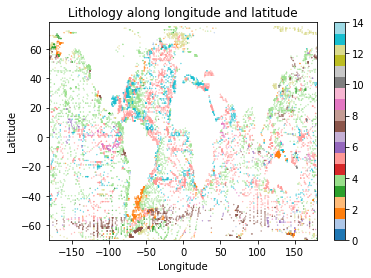

In [16]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.1, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

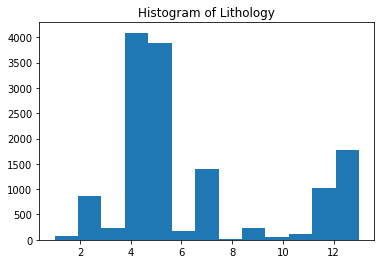

In [25]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y, bins=13)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

In [18]:
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from keras.utils import np_utils


training_data = dfdata.copy()

to_remove = ['longitude', 'latitude', 'lithology', 'label', 'lon', 'lat']

features = []
for name in training_data:
    if name not in to_remove:
        features.append(name)
        
# obtain list of feature names
target = "lithology"

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

display(training_data.head())

# fix random seed for reproducibility
seed = 0
np.random.seed(seed)
X = training_data[features].astype(float)
Y = training_data[target]
display(X.head())

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

,longitude,latitude,lithology,bathymetry,temperature,salinity,productivity,lon,lat,label
0,-19,75,4,-167.0,-1.930649,30.408110,727.085754,-19,75,4
1,-19,75,4,-167.0,-1.930649,30.408110,727.085754,-19,75,12
2,-19,75,4,-167.0,-1.930649,30.408110,727.085754,-19,75,12
3,-18,75,4,-115.0,-2.038240,31.694929,646.117432,-18,75,4
4,-18,75,4,-115.0,-2.038240,31.694929,646.117432,-18,75,4


,bathymetry,temperature,salinity,productivity
0,-167.0,-1.930649,30.408110,727.085754
1,-167.0,-1.930649,30.408110,727.085754
2,-167.0,-1.930649,30.408110,727.085754
3,-115.0,-2.038240,31.694929,646.117432
4,-115.0,-2.038240,31.694929,646.117432


### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.
The neural network has the following structure:

- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Output layer

In [19]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

In [20]:
# define baseline model
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(numclass, activation="softmax", kernel_initializer=initializer))
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# class reweighting for imbalanced class
weight = {i: x for i, x in enumerate(class_weight.compute_class_weight('balanced', np.unique(Y), Y))}
print(weight)
print(X.shape)
print(Y.shape)

{0: 13.243114909781577, 1: 1.23015172900494, 2: 4.488252333440618, 3: 0.2623360987264142, 4: 0.276253491550942, 5: 5.926476838079048, 6: 0.7700590866420012, 7: 89.39102564102564, 8: 4.684245885119248, 9: 18.4946949602122, 10: 9.932336182336183, 11: 1.053725253135862, 12: 0.6019597686264353}
(13945, 4)
(13945,)


/Users/wan220/.virtualenvs/sea2/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], y=[3 3 3 ... 6 6 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=3, shuffle=True, random_state=seed)

train_indice, test_indice = [], []
for train, test in kfold.split(X):
    train_indice.append(train)
    test_indice.append(test)
    
result = np.zeros((len(Y), len(np.unique(Y))))


print(baseline_model().summary())

estimators = []
histories = []
for train_ind, test_ind in kfold.split(X):
    Xtrain = X[train_ind]
    Ytrain = dummy_Y[train_ind]
    Xtest = X[test_ind]
    # train
    estimator = KerasClassifier(build_fn=baseline_model, epochs=1500, batch_size=50, verbose=False)
    history = estimator.fit(X[train_ind], dummy_Y[train_ind], class_weight=weight)
    # predict
    prediction = estimator.predict_proba(X[test_ind])
    print(f"Training: Accuracy={accuracy_score(Y[train_ind], estimator.predict(X[train_ind]))}")
    print(f"Testing : Accuracy={accuracy_score(Y[test_ind], estimator.predict(X[test_ind]))}")
    result[test_ind, :] = prediction
    estimators.append(estimator)
    histories.append(history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 13)                429       
Total params: 11,405
Trainable params: 11,405
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if yo

In [ ]:
estimator.predict_proba(X[test_ind])

In [23]:
result_discrete = result.argmax(axis=1)
result_discrete

array([11, 11, 11, ..., 11, 11, 11])

Accuracy = 0.5691645751165292


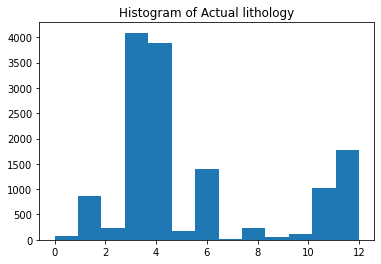

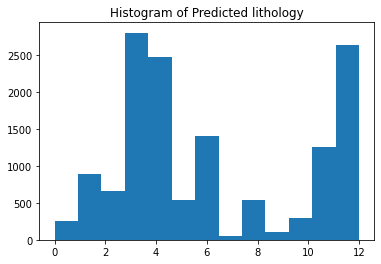

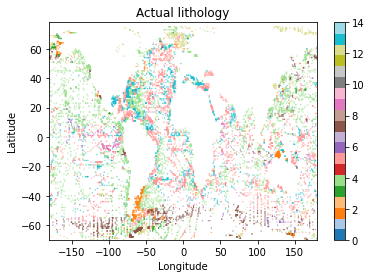

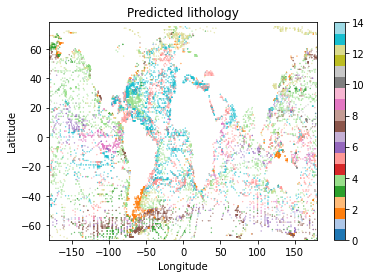

In [26]:
print("Accuracy = {}".format(accuracy_score(Y, result_discrete)))
draw_hist(Y, "Histogram of Actual lithology")
draw_hist(result_discrete, "Histogram of Predicted lithology")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, result_discrete + 1, "Predicted lithology")

In [ ]:
prob = np.max(result, axis=1)
draw_global(lon, lat, prob, "Probability of Predicted Label", cmap='RdBu_r', vmin=0, vmax=1)

In [ ]:
accuracy_score(estimator.predict_proba(X).argmax(axis=1), Y)

In [ ]:
query_data = pd.read_csv("data/train_clean.csv")

# obtain list of feature names
target = "lithology"
features = list(query_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

Xq = query_data[features].astype(float)
Xq = scaler.fit_transform(Xq)

prediction = estimator.predict_proba(Xq)
q_discrete = prediction.argmax(axis=1)
q_prob = prediction[:, q_discrete]


draw_global(query_data['longitude'], query_data['latitude'], q_discrete + 1, "Predicted lithology")

In [ ]:
q_prob = np.max(prediction, axis=1)
draw_global(query_data['longitude'], query_data['latitude'], q_prob, "Probability of Predicted Label", cmap='RdBu_r', vmin=0, vmax=1)

In [ ]:
to_save = pd.DataFrame({"lon": query_data['longitude'], 
                        "lat": query_data['latitude'], 
                        "result_discrete": q_discrete, 
                        "prob": q_prob})
to_save.to_csv("result_with14k.csv", index=False)
to_save


In [ ]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as pl

result = pd.read_csv("result_with14k.csv")

import matplotlib as mpl

rgbs = np.array([
    [128, 130, 132],
    [255, 241, 0],
    [250, 169, 25],
    [112, 75, 42],
    [14, 145, 207],
    [13, 150, 71],
    [190, 215, 83],
    [85, 147, 141],
    [131, 112, 178],
    [247, 187, 213],
    [234, 27, 27],
    [195, 154, 107],
    [0, 46, 167]
]) / 255


cmap = mpl.colors.ListedColormap(rgbs)
boundaries = list(range(1, 14))
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

lithology_mapping = {
    1: "Gravel and coarser",
    2: "Sand",
    3: "Silt",
    4: "Clay",
    5: "Calcareous ooze",
    6: "Radiolarian ooze",
    7: "Diatom ooze",
    8: "Sponge spicules",
    9: "Mixed calcareous/siliceous ooze",
    10: "Shells and coral fragments",
    11: "Ash and volcanic sand/gravel",
    12: "Siliceous mud",
    13: "Fine-grained calcareous sediment"
}

In [ ]:
pl.figure(figsize=(24, 20))
ax = pl.axes(projection=ccrs.Mollweide())
ax.stock_img()
ax.coastlines()
ax.scatter(result['lon'], result['lat'], c=result['result_discrete'] + 1,
           cmap=cmap, s=2, norm=norm, transform=ccrs.PlateCarree())
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

# cb = pl.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.046, pad=0.04)
cb = pl.colorbar(sm, ax=ax, 
#                  orientation="horizontal", 
                 ticks=list(lithology_mapping.keys()), 
                 fraction=0.02, pad=0.04)
cb.ax.set_yticklabels(list(lithology_mapping.values()))
# cb.ax.set_xlabel("Probability of Predicted Label")
ax.set_title("Lithology Prediction")
pl.savefig("Lithology_Prediction.png")
pl.show()

In [ ]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

pl.figure(figsize=(16, 12))
ax = pl.axes(projection=ccrs.Mollweide())
ax.stock_img()
ax.coastlines()
ax.scatter(result['lon'], result['lat'], c=result['prob'],
           cmap='RdBu_r', s=1, transform=ccrs.PlateCarree())
# ax.colorbar()
sm = pl.cm.ScalarMappable(cmap='RdBu_r', norm=pl.Normalize(0,1))
sm._A = []
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.05)
cb = pl.colorbar(sm, ax=ax, 
#                  orientation="horizontal", 
                 fraction=0.02, pad=0.04)
# cb.ax.set_xlabel("Probability of Predicted Label")
ax.set_title("Probability of Predicted Lithology Label")
pl.savefig("Lithology_Prediction_Probability.png")
pl.show()